In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import sys

from joblib import dump, load
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

from functions import *

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/processed/sales_for_modelling.csv')

In [3]:
df.head()

,index,Value,Holiday,time,mdate,day,week,month,year
0,2013-11-07 13:00,34.57,NaN,13,7,3,45,11,2013
1,2013-11-07 14:00,22.50,NaN,14,7,3,45,11,2013
2,2013-11-07 15:00,0.00,NaN,15,7,3,45,11,2013
3,2013-11-07 16:00,7.29,NaN,16,7,3,45,11,2013
4,2013-11-07 17:00,0.00,NaN,17,7,3,45,11,2013


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39391 entries, 0 to 39390
Data columns (total 9 columns):
index      39391 non-null object
Value      39391 non-null float64
Holiday    1104 non-null object
time       39391 non-null int64
mdate      39391 non-null int64
day        39391 non-null int64
week       39391 non-null int64
month      39391 non-null int64
year       39391 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 2.7+ MB


In [5]:
df['index'] = pd.to_datetime(df['index'])

In [6]:
df.set_index('index', inplace = True)

In [7]:
df.isna().sum()

Value          0
Holiday    38287
time           0
mdate          0
day            0
week           0
month          0
year           0
dtype: int64

In [8]:
df.index.min()

Timestamp('2013-11-07 13:00:00')

In [9]:
df.index.max()

Timestamp('2018-05-06 19:00:00')

Again for this model we'll only be using sales for the time being as modelling with this type of data is already challenging.

In [10]:
# dropping all unnecessary columns
df.drop(['Holiday', 'time', 'mdate', 'day', 'week', 'month', 'year'], axis =1, inplace = True)




# Splitting into Training/Validation/Test

Moving forward we'll be using training and validation on the LSTM models while keeping the test set for the last final check on our winning model. 

Ratios will be 80/20 for initial training/test split and I'll further split the training dataset into final training and validation (still 80/20)

In [11]:
# Set train/test time split
train_start  = pd.to_datetime('2013110700', format='%Y%m%d%H', errors='ignore') 
train_end    = pd.to_datetime('2016102023', format='%Y%m%d%H', errors='ignore')
validation_start   = train_end  + pd.Timedelta(hours=1)
validation_end    = pd.to_datetime('2017070823', format='%Y%m%d%H', errors='ignore')

test_start  = pd.to_datetime('2017070900', format='%Y%m%d%H', errors='ignore')
test_end = pd.to_datetime('2018050619', format='%Y%m%d%H', errors='ignore')

# Assign train/test data frames
df_train = df.loc[train_start:train_end]
df_validation = df.loc[validation_start:validation_end]
df_test  = df.loc[test_start:]
print('Overall Training/Test set ratio: {r}'.format(r=round((len(df_test))/(len(df_train)+len(df_validation)+len(df_test)),2)))

print('Final Training/Validation ratio: {r}'.format(r=round(len(df_validation)/(len(df_train)+len(df_validation)),2)))



Overall Training/Test set ratio: 0.18
Final Training/Validation ratio: 0.19


In [12]:
df_test

,Value
index,
2017-07-09 00:00:00,0.00
2017-07-09 01:00:00,0.00
2017-07-09 02:00:00,0.00
2017-07-09 03:00:00,0.00
2017-07-09 04:00:00,0.00
...,...
2018-05-06 15:00:00,36.45
2018-05-06 16:00:00,33.72
2018-05-06 17:00:00,30.77


In [13]:
print(df_train.shape)
print(df_validation.shape)
print(df_test.shape)


(25883, 1)
(6264, 1)
(7244, 1)


In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(df_train)
scaled_val = scaler.transform(df_validation)
scaled_test = scaler.transform(df_test)

In [15]:
dump(scaler, 'scaler_training')

['scaler_training']

The function below prepares data to be fed into the LSTM neural network. The two terms n_in and n_out refers respectively to how many **timesteps** I want to use to predict the current value t in the future (so in this case we have a look back of 24 hours) while the second refers to the number of variables I want to use which in this case is only sales.
I'll apply the function across all three datasets.

In this case, (and for computational reason) I'll limit the analysis to a full day cycle which is equal to 24 time steps in my dataset. The last term will be set at 1 since we have only the 'sales' variable.

In [16]:
n_steps = 24
reframed_training = series_to_supervised(scaled_train,n_steps,1) 
reframed_validation = series_to_supervised(scaled_val,n_steps,1) 
reframed_test = series_to_supervised(scaled_test,n_steps,1) 

In [17]:
reframed_training.head()

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.581399,0.378406,0.000000,0.122603,0.000000,0.274638,0.000000,0.127144,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.127312,0.371510,1.000000,0.921628,0.711234,0.725362
25,0.378406,0.000000,0.122603,0.000000,0.274638,0.000000,0.127144,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.127312,0.371510,1.000000,0.921628,0.711234,0.725362,0.709216
26,0.000000,0.122603,0.000000,0.274638,0.000000,0.127144,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.127312,0.371510,1.000000,0.921628,0.711234,0.725362,0.709216,0.677262
27,0.122603,0.000000,0.274638,0.000000,0.127144,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.127312,0.371510,1.000000,0.921628,0.711234,0.725362,0.709216,0.677262,0.620249
28,0.000000,0.274638,0.000000,0.127144,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.127312,0.371510,1.000000,0.921628,0.711234,0.725362,0.709216,0.677262,0.620249,0.606290


As you can see above the new dataframe has 24 additional timesteps which it will be used by the LSTM model to make estimates on the point t+1. Below I am also converting all datasets into arrays.

In [18]:
values_training = reframed_training.values
values_validation = reframed_validation.values
values_test = reframed_test.values

Splitting the below into input and outputs, so t(-24)... to t(-1) from t itself.

In [19]:
train_X, train_y = values_training [:, :-1], values_training [:, -1]
validation_X, validation_y = values_validation[:, :-1], values_validation[:, -1]

test_X, test_y = values_test[:, :-1], values_test[:, -1]

Finally the LSTM needs inputs in the form of [number of samples, timesteps and features]. 

In [20]:
# features set at one since as mentioned before we are only looking at sales
n_features = 1

In [21]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
validation_X = validation_X.reshape((validation_X.shape[0], validation_X.shape[1], n_features))

test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))



In [22]:
print(train_X.shape)
print(validation_X.shape)
print(test_X.shape)

(25859, 24, 1)
(6240, 24, 1)
(7220, 24, 1)


# Baseline Long-Short-Term-Memory (LSTM) Model

In [23]:
model_1 = Sequential()
model_1.add (LSTM(100,input_shape=(train_X.shape[1], train_X.shape[2])))
model_1.add(Dense(1))

model_1.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_1 = model_1.fit(train_X, train_y, 
                    epochs=10, batch_size=70, 
                    validation_data=(validation_X, validation_y), 
                    verbose=2, shuffle=False)

Train on 25859 samples, validate on 6240 samples
Epoch 1/10
 - 13s - loss: 0.0189 - val_loss: 0.0125
Epoch 2/10
 - 15s - loss: 0.0113 - val_loss: 0.0091
Epoch 3/10
 - 13s - loss: 0.0091 - val_loss: 0.0081
Epoch 4/10
 - 14s - loss: 0.0085 - val_loss: 0.0078
Epoch 5/10
 - 13s - loss: 0.0080 - val_loss: 0.0082
Epoch 6/10
 - 16s - loss: 0.0082 - val_loss: 0.0078
Epoch 7/10
 - 12s - loss: 0.0076 - val_loss: 0.0072
Epoch 8/10
 - 11s - loss: 0.0073 - val_loss: 0.0070
Epoch 9/10
 - 12s - loss: 0.0072 - val_loss: 0.0069
Epoch 10/10
 - 11s - loss: 0.0072 - val_loss: 0.0068


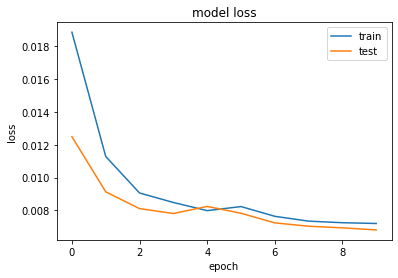

In [26]:
plot_loss(history_1)

In [27]:
validation_y

array([0., 0., 0., ..., 0., 0., 0.])

I'll be using the function below throughout the notebook to plot predictions and observed values across the number of time steps (hours) for both training and validation datasets. This function also returns the Mean Sqaured Error value across the entire training and validation sets (not only the plotted visible ones).

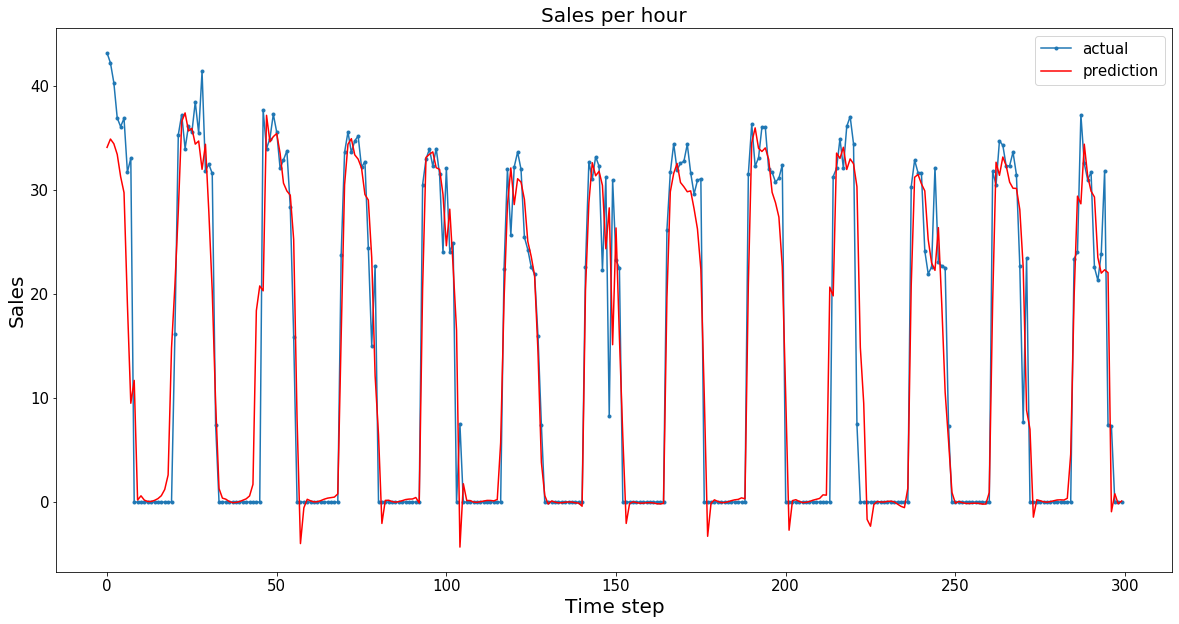

MSE: 23.449


In [28]:
mse_plot_pred(model_1,train_X, train_y, 300)

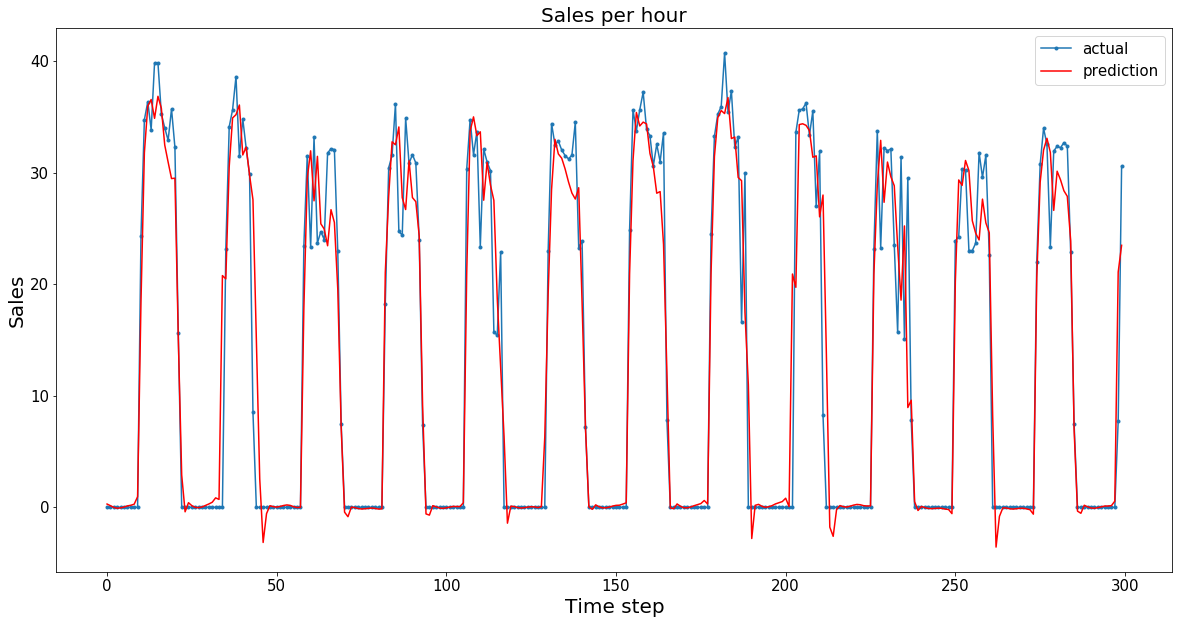

MSE: 24.075


In [29]:
mse_plot_pred(model_1,validation_X, validation_y, 300)

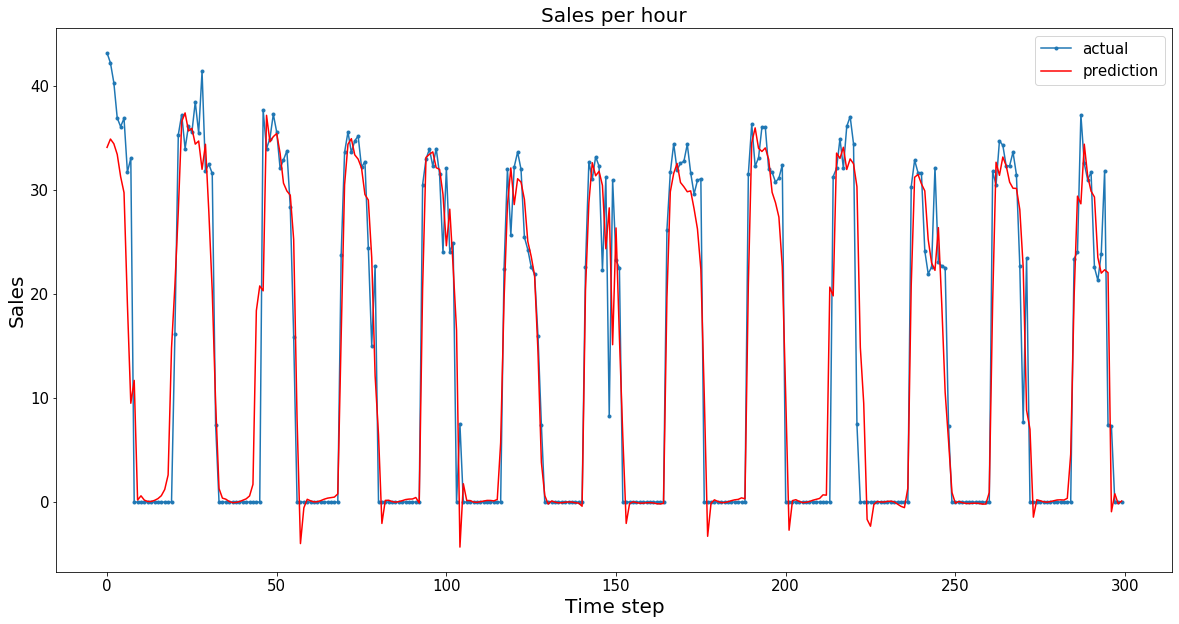

MSE: 23.449


In [30]:
mse_plot_pred(model_1,train_X, train_y, 300)

In [31]:
validation_X.shape

(6240, 24, 1)

# Adding another LSTM layer, Dropouts and increasing number of nodes

There were very timid signs of overfitting with the validation results very close to the training ones.

In order to mitigate this issue, I'll introduce some droputs layers while also increasing number of neurons from a 100 to 120.
I am also adding another LSTM layer with 70 nodes.

In [32]:
model_2 = Sequential()

model_2.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(70))
model_2.add(Dense(1))

model_2.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 120)           58560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 120)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                53480     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 71        
Total params: 112,111
Trainable params: 112,111
Non-trainable params: 0
_________________________________________________________________


In [34]:
history_2 = model_2.fit(train_X, train_y, 
                    epochs=10, batch_size=70, 
                    validation_data=(validation_X, validation_y), 
                    verbose=2, shuffle=False)

Train on 25859 samples, validate on 6240 samples
Epoch 1/10
 - 32s - loss: 0.0191 - val_loss: 0.0138
Epoch 2/10
 - 31s - loss: 0.0122 - val_loss: 0.0092
Epoch 3/10
 - 27s - loss: 0.0093 - val_loss: 0.0078
Epoch 4/10
 - 27s - loss: 0.0084 - val_loss: 0.0076
Epoch 5/10
 - 27s - loss: 0.0077 - val_loss: 0.0075
Epoch 6/10
 - 27s - loss: 0.0075 - val_loss: 0.0077
Epoch 7/10
 - 31s - loss: 0.0073 - val_loss: 0.0072
Epoch 8/10
 - 44s - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
 - 43s - loss: 0.0072 - val_loss: 0.0071
Epoch 10/10
 - 45s - loss: 0.0069 - val_loss: 0.0071


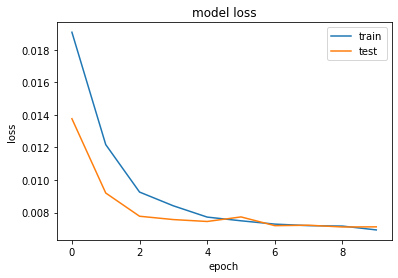

In [35]:
plot_loss(history_2)

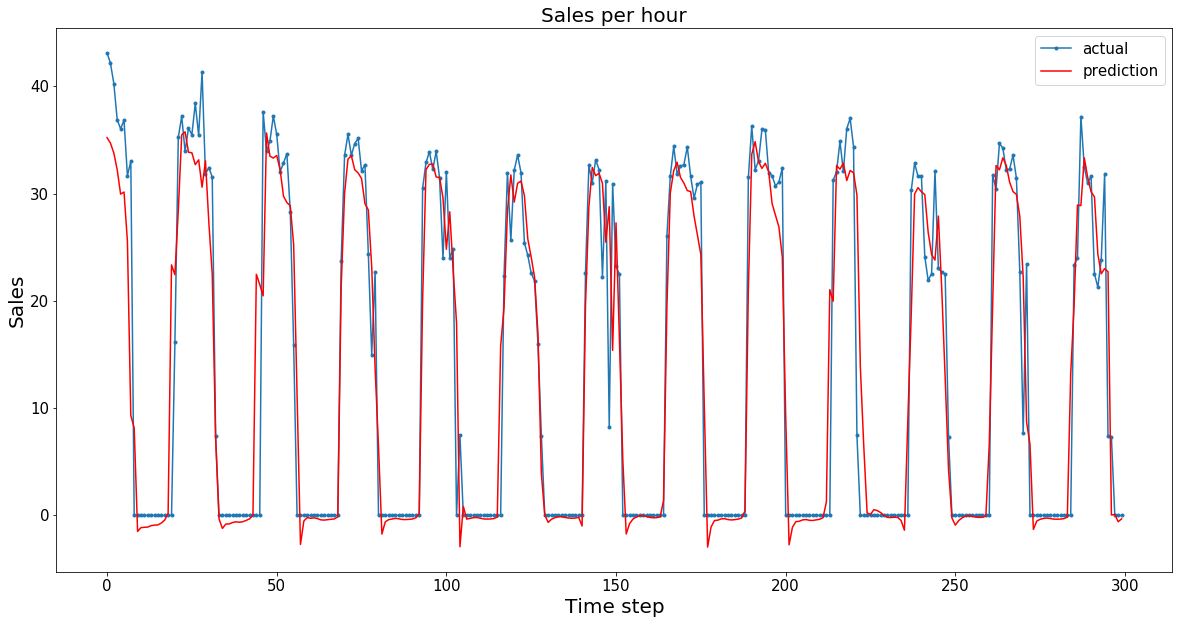

MSE: 24.012


In [36]:
mse_plot_pred(model_2,train_X, train_y, 300)

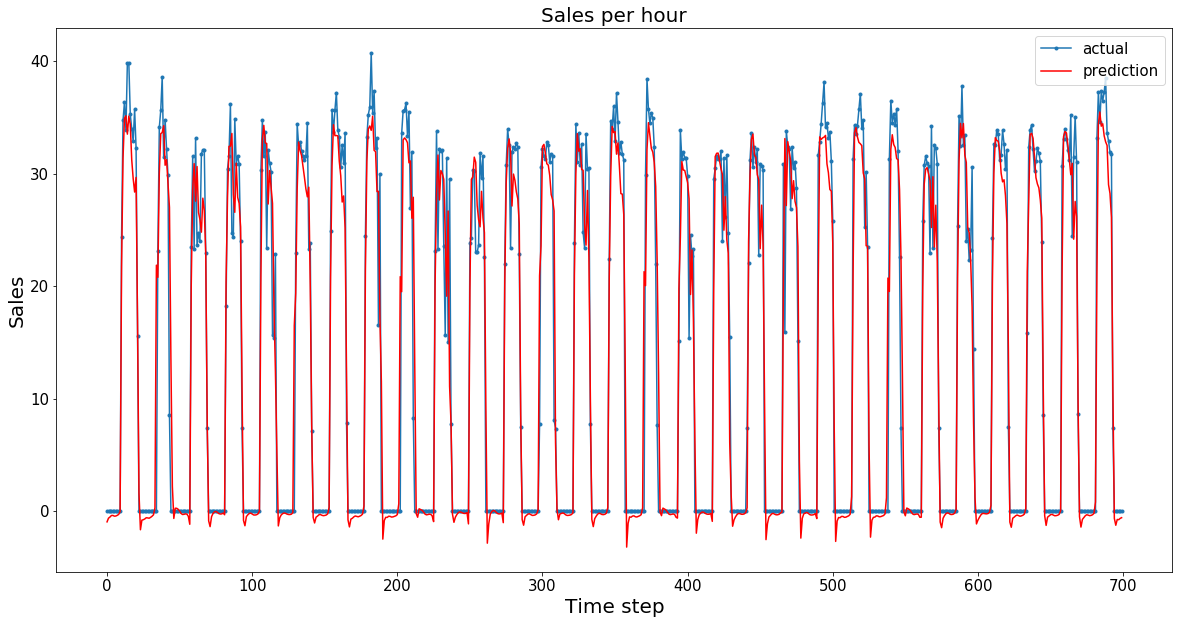

MSE: 25.180


In [37]:
mse_plot_pred(model_2,validation_X, validation_y, 700)

#  Changing Activation Functions

So far the activation function has been set to the default'tanh' which is the hyperbolic tangent activation function. Ranges of values for this activation function goes from -1 to 1.

This translates into the predictions by exaggerating very positive or negative values.
Up to this point, we have seen quite a few negative results during the closing hours. I'll introduce another quite popular activation function ('relu') which has a different range (0 to infinity) and should in theory help smooth those negative values we are finding so far.



In [38]:
model_3 = Sequential()

model_3.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2]), 
                 return_sequences=True,
                 activation = 'relu'))

model_3.add(Dropout(0.2))
model_3.add(LSTM(70, activation= 'relu'))
model_3.add(Dense(1))

model_3.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
history_3 = model_3.fit(train_X, train_y, 
                    epochs=10, batch_size=70, 
                    validation_data=(validation_X, validation_y), 
                    verbose=2, shuffle=False)

Train on 25859 samples, validate on 6240 samples
Epoch 1/10
 - 41s - loss: 0.0224 - val_loss: 0.0103
Epoch 2/10
 - 41s - loss: 0.0101 - val_loss: 0.0089
Epoch 3/10
 - 36s - loss: 0.0089 - val_loss: 0.0082
Epoch 4/10
 - 35s - loss: 0.0081 - val_loss: 0.0075
Epoch 5/10
 - 27s - loss: 0.0076 - val_loss: 0.0072
Epoch 6/10
 - 27s - loss: 0.0073 - val_loss: 0.0070
Epoch 7/10
 - 27s - loss: 0.0071 - val_loss: 0.0067
Epoch 8/10
 - 27s - loss: 0.0069 - val_loss: 0.0069
Epoch 9/10
 - 28s - loss: 0.0068 - val_loss: 0.0067
Epoch 10/10
 - 30s - loss: 0.0066 - val_loss: 0.0066


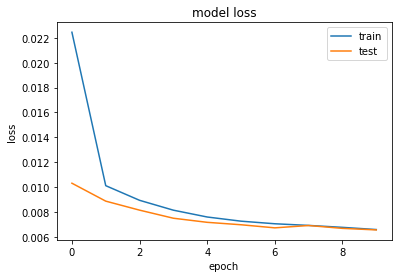

In [40]:
plot_loss(history_3)

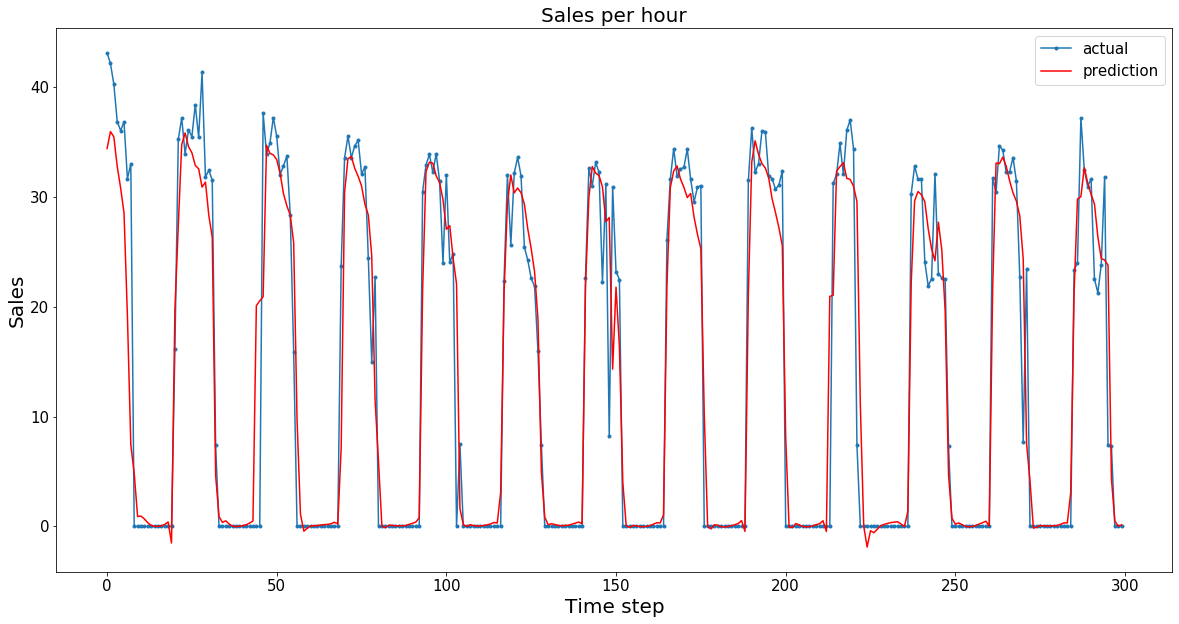

MSE: 21.457


In [41]:
mse_plot_pred(model_3,train_X, train_y, 300)

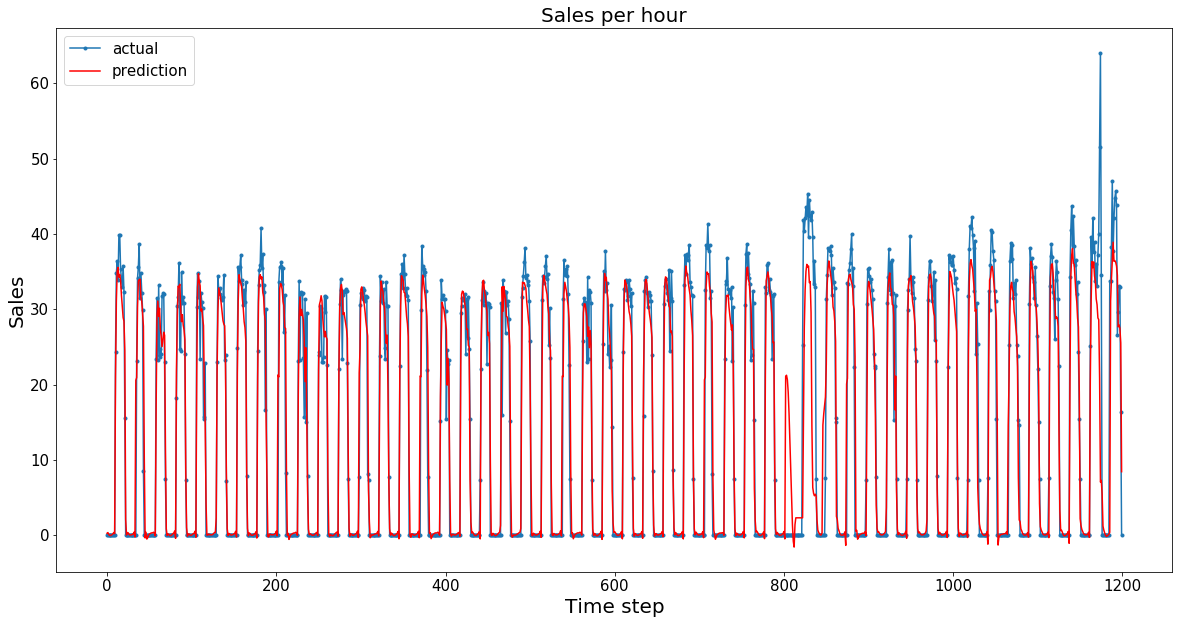

MSE: 23.203


In [42]:
mse_plot_pred(model_3,validation_X, validation_y, 1200)

MSE has sligtly went down but unfortuntaley all the negative values are still present.

# Increasing number of epochs to 20

In [43]:
model_4 = Sequential()

model_4.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2]), 
                 return_sequences=True,
                 activation = 'relu'))

model_4.add(Dropout(0.2))
model_4.add(LSTM(70, 
            activation= 'relu'))

model_4.add(Dense(1))

model_4.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
history_4 = model_4.fit(train_X, train_y, 
                    epochs=20, batch_size=70, 
                    validation_data=(validation_X, validation_y), 
                    verbose=2, shuffle=False)

Train on 25859 samples, validate on 6240 samples
Epoch 1/20
 - 28s - loss: 0.0241 - val_loss: 0.0115
Epoch 2/20
 - 27s - loss: 0.0108 - val_loss: 0.0090
Epoch 3/20
 - 27s - loss: 0.0091 - val_loss: 0.0083
Epoch 4/20
 - 27s - loss: 0.0085 - val_loss: 0.0079
Epoch 5/20
 - 27s - loss: 0.0082 - val_loss: 0.0077
Epoch 6/20
 - 27s - loss: 0.0077 - val_loss: 0.0075
Epoch 7/20
 - 27s - loss: 0.0075 - val_loss: 0.0072
Epoch 8/20
 - 27s - loss: 0.0073 - val_loss: 0.0072
Epoch 9/20
 - 27s - loss: 0.0071 - val_loss: 0.0070
Epoch 10/20
 - 27s - loss: 0.0069 - val_loss: 0.0068
Epoch 11/20
 - 27s - loss: 0.0068 - val_loss: 0.0068
Epoch 12/20
 - 27s - loss: 0.0068 - val_loss: 0.0068
Epoch 13/20
 - 27s - loss: 0.0066 - val_loss: 0.0067
Epoch 14/20
 - 27s - loss: 0.0066 - val_loss: 0.0066
Epoch 15/20
 - 27s - loss: 0.0065 - val_loss: 0.0065
Epoch 16/20
 - 28s - loss: 0.0064 - val_loss: 0.0064
Epoch 17/20
 - 27s - loss: 0.0064 - val_loss: 0.0064
Epoch 18/20
 - 27s - loss: 0.0065 - val_loss: 0.0071
Epoch 

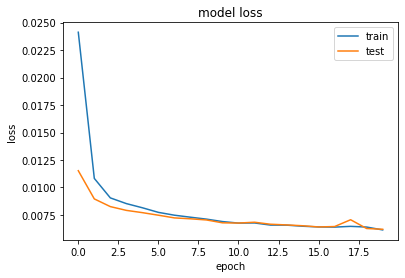

In [45]:
plot_loss(history_4)

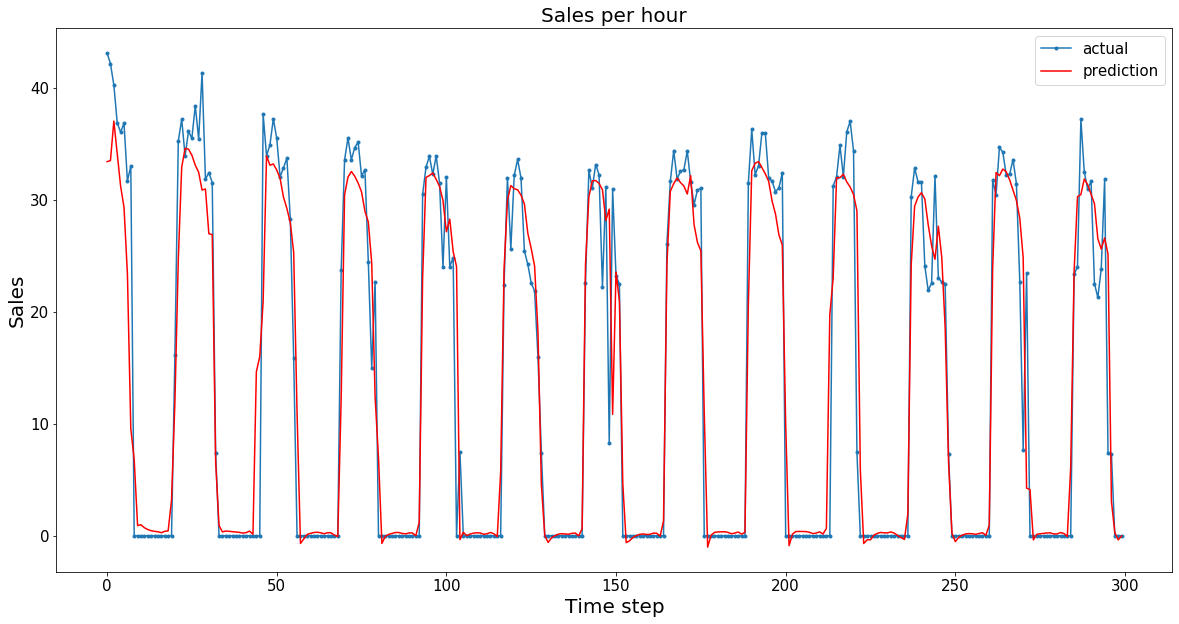

MSE: 20.321


In [46]:
mse_plot_pred(model_4,train_X, train_y, 300)

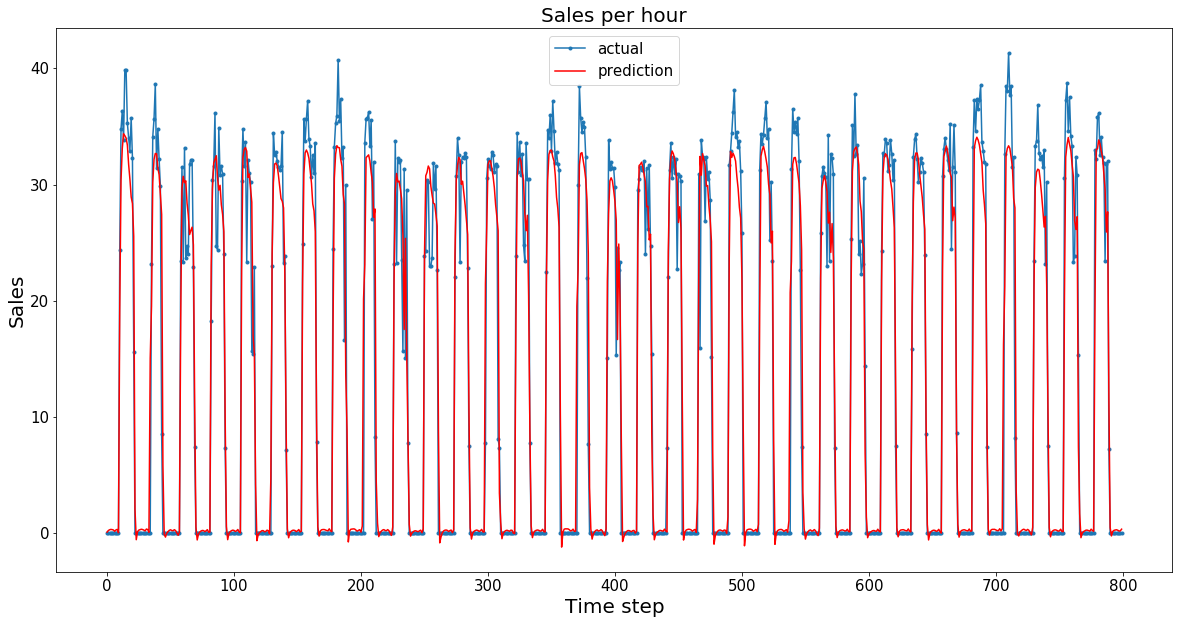

MSE: 21.914


In [47]:
mse_plot_pred(model_4,validation_X, validation_y, 800)

# Changing batch size to 168 weekly

In [48]:
model_5 = Sequential()

model_5.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2]), 
                 return_sequences=True,
                 activation = 'relu'))

model_5.add(Dropout(0.2))
model_5.add(LSTM(70, 
            activation= 'relu'))

model_5.add(Dense(1))

model_5.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
history_5 = model_5.fit(train_X, train_y, 
                    epochs=10, batch_size=168, 
                    validation_data=(validation_X, validation_y), 
                    verbose=2, shuffle=False)

Train on 25859 samples, validate on 6240 samples
Epoch 1/10
 - 22s - loss: 0.0302 - val_loss: 0.0149
Epoch 2/10
 - 21s - loss: 0.0141 - val_loss: 0.0118
Epoch 3/10
 - 21s - loss: 0.0115 - val_loss: 0.0098
Epoch 4/10
 - 24s - loss: 0.0101 - val_loss: 0.0094
Epoch 5/10
 - 24s - loss: 0.0093 - val_loss: 0.0087
Epoch 6/10
 - 22s - loss: 0.0087 - val_loss: 0.0082
Epoch 7/10
 - 25s - loss: 0.0082 - val_loss: 0.0078
Epoch 8/10
 - 23s - loss: 0.0079 - val_loss: 0.0074
Epoch 9/10
 - 22s - loss: 0.0076 - val_loss: 0.0073
Epoch 10/10
 - 24s - loss: 0.0075 - val_loss: 0.0070


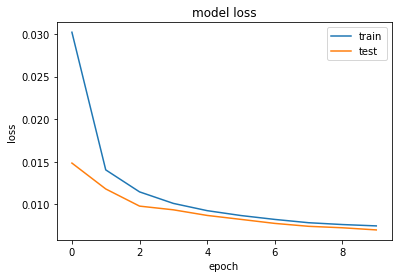

In [50]:
plot_loss(history_5)

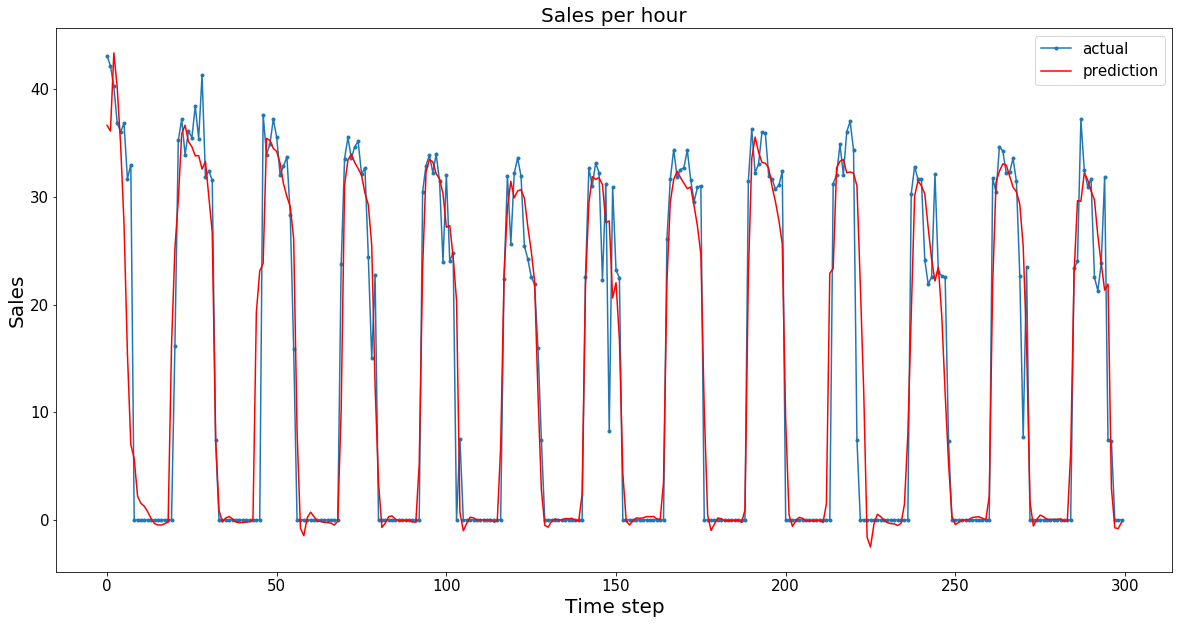

MSE: 23.728


In [51]:
mse_plot_pred(model_5,train_X, train_y, 300)

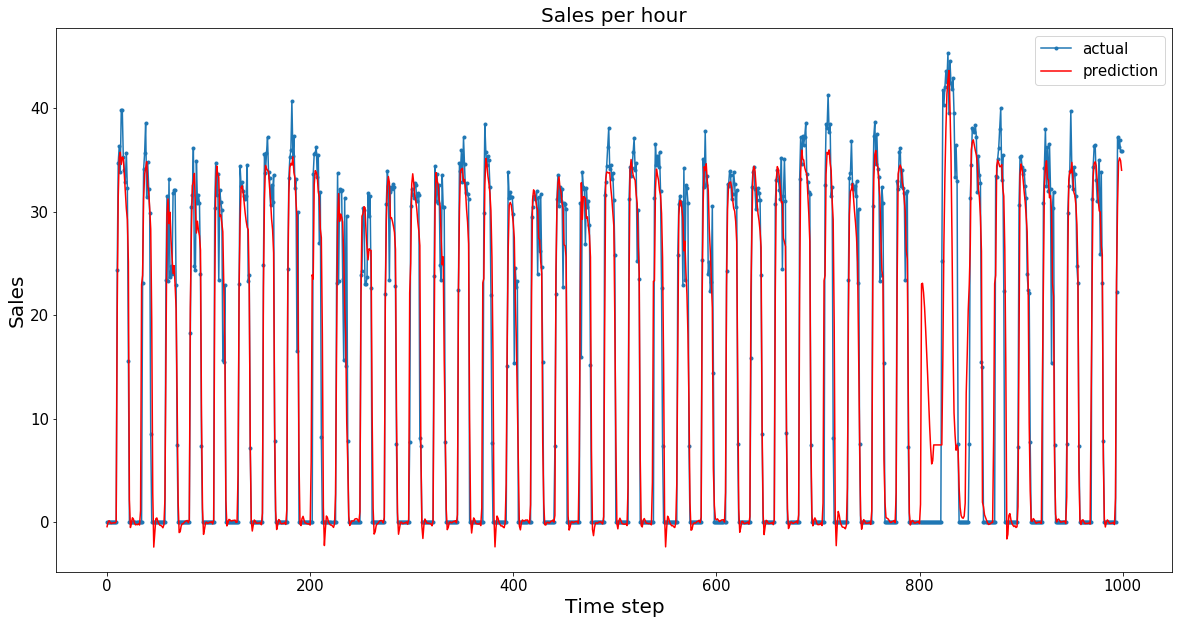

MSE: 24.795


In [52]:
mse_plot_pred(model_5,validation_X, validation_y, 1000)

# Testing Winning Model 4 on Test Set

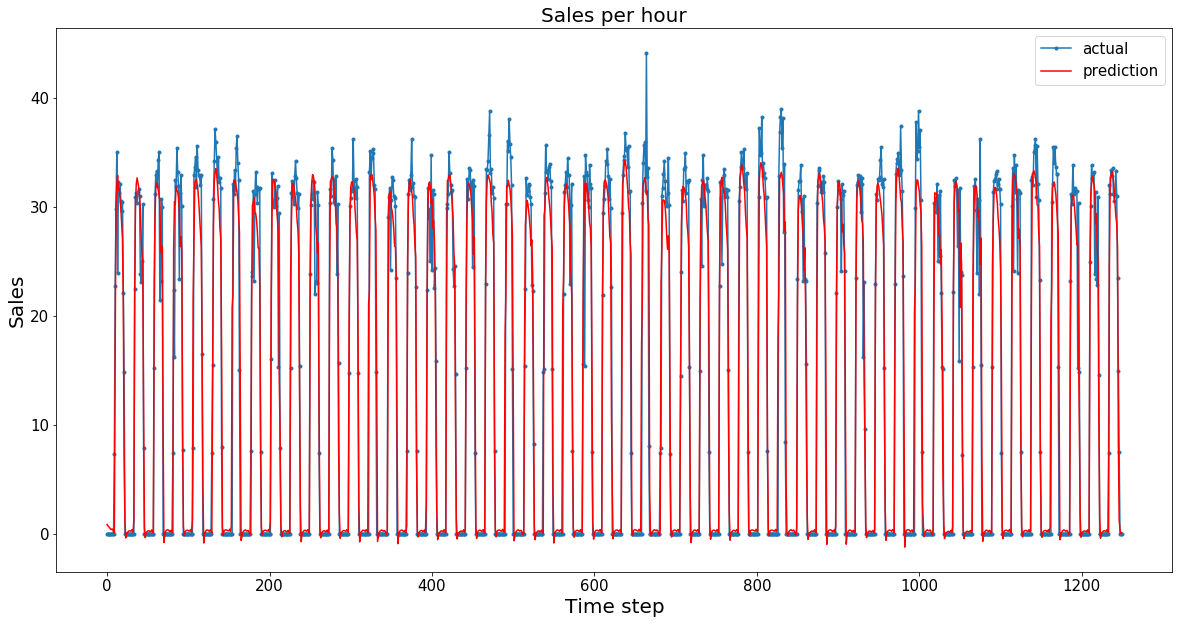

MSE: 21.932


In [53]:
mse_plot_pred(model_4, test_X, test_y, 1250)

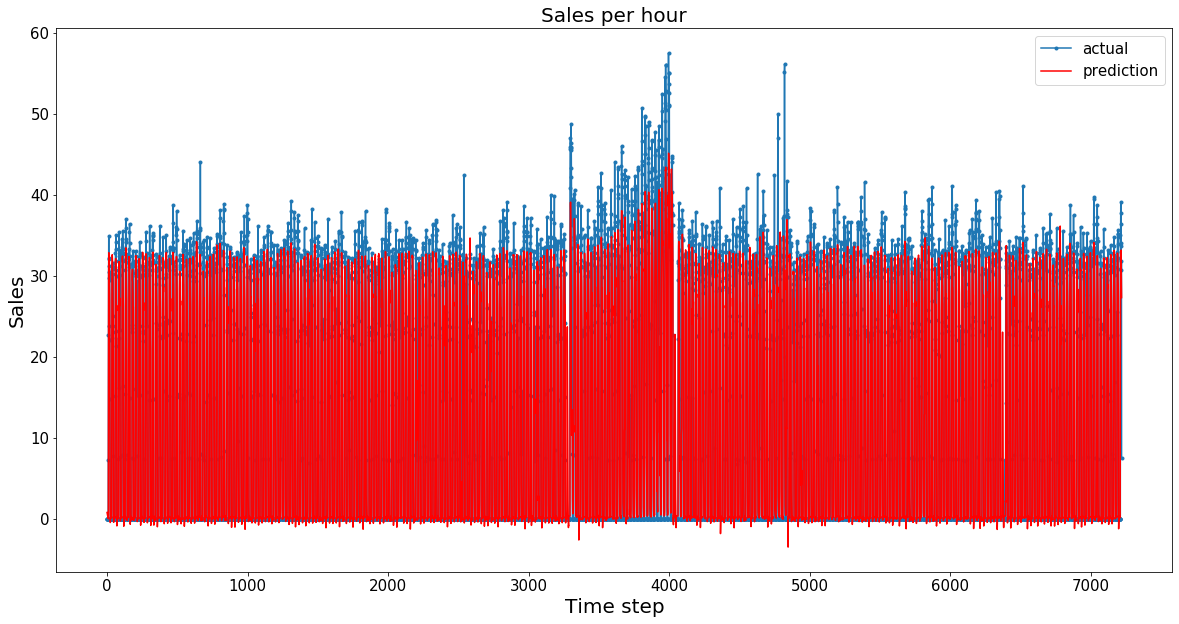

MSE: 21.932


In [54]:
mse_plot_pred(model_4, test_X, test_y, 7220)